# Assignment 3: **Image classification Neural Network**
---

## Introduction

This notebook contains my solution for the fourth assignment in which it is required to model two neural networks for the classification of images and train them on the two datasets *MNIST* and *CIFAR*.

To carry out the exercise I used the following packages and libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam

To view the progress of the network training about *loss* and *accuracy*, I have defined the following function. 

In [ ]:
# Function for Model Training Visualization
def plot_history(network_history, n_epochs):
  x_plot = list(range(1,n_epochs+1))
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, network_history.history['loss'])
  plt.plot(x_plot, network_history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, network_history.history['accuracy'])
  plt.plot(x_plot, network_history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right')
  plt.show()

## Data

As required by the instructions, to carry out the assignment I used the two datasets *MNIST* and *CIFAR*, which consist respectively of:
* $28\times 28$ B/W images of hand-written digits (from $0$ to $9$: $10$ different classes);
* $32\times 32$ colored images belonging to $10$ different categories.

In [ ]:
# Definition Target Classes and Input Data Shape
num_classes = 10
MNISTinput_shape = (28,28,1)
CIFARinput_shape = (32,32,3)

# Import MNIST from Keras
(MNISTx_train, MNISTy_train), \
(MNISTx_test, MNISTy_test) = keras.datasets.mnist.load_data()

# Import CIFAR from Keras
(CIFARx_train, CIFARy_train), \
(CIFARx_test, CIFARy_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


First of all I defined the function `preProcessing(x_train, x_test, y_train, y_test, name)` which applies transformations to the input data to adapt them to the task of the exercise. The `name` parameter was used as placeholder to distinguish between the two different datasets, which require different transformations.

Then this function makes changes to the datasets by applying type conversions. In particular, it converts the data to float normalizing them according to the maximum value $255$.

Next, for the *MNIST* dataset only, it reshapes the train and test images by adding a dimension. Finally, for both datasets, the function applies a conversion on the *y*s (train and test) passing from categorical to binary vectors. 

In [ ]:
def preProcessing(x_train, x_test, y_train, y_test, n_cls, name):

  print('Original Data...')
  print('X train shape:', x_train.shape)
  print('X test shape:', x_test.shape)
  print('Y train shape:', y_train.shape)
  print('Y test shape:', y_test.shape)

  # Scaling Images [0,255] to [0,1]
  x_train = x_train.astype('float32')/255
  x_test = x_test.astype('float32')/255

  if name == 'MNIST':
    # Images Reshape to 28x28x1
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

  # Conversion of Categorical Target Vectors to Binary Matrices
  # by One-Hot Encoding 
  y_train = keras.utils.to_categorical(y_train, n_cls)
  y_test = keras.utils.to_categorical(y_test, n_cls)

  print('...')
  print('...')
  print('Preprocessed Data...')
  if name == 'CIFAR':
    print('The Xs data already have the color dimension.')
  print('X train shape:', x_train.shape)
  print('X test shape:', x_test.shape)
  print('Y train shape:', y_train.shape)
  print('Y test shape:', y_test.shape)

  return x_train, x_test, y_train, y_test

In [ ]:
MNISTx_train, MNISTx_test, \
MNISTy_train, MNISTy_test = preProcessing(MNISTx_train, MNISTx_test,
                                          MNISTy_train, MNISTy_test,
                                          num_classes, 'MNIST')

Original Data...
X train shape: (60000, 28, 28)
X test shape: (10000, 28, 28)
Y train shape: (60000,)
Y test shape: (10000,)
...
...
Preprocessed Data...
X train shape: (60000, 28, 28, 1)
X test shape: (10000, 28, 28, 1)
Y train shape: (60000, 10)
Y test shape: (10000, 10)


In [ ]:
CIFARx_train, CIFARx_test, \
CIFARy_train, CIFARy_test = preProcessing(CIFARx_train, CIFARx_test,
                                          CIFARy_train, CIFARy_test,
                                          num_classes, 'CIFAR')

Original Data...
X train shape: (50000, 32, 32, 3)
X test shape: (10000, 32, 32, 3)
Y train shape: (50000, 1)
Y test shape: (10000, 1)
...
...
Preprocessed Data...
The Xs data already have the color dimension.
X train shape: (50000, 32, 32, 3)
X test shape: (10000, 32, 32, 3)
Y train shape: (50000, 10)
Y test shape: (10000, 10)


## Convolutional Neural Network **CNN**

### Function definitions for CNN modeling, training and evaluation 

To the create, train and evaluate the two models I have defined the following functions.

In [ ]:
def createCNN(input_shape, n_cls):
  
  tf.keras.backend.clear_session()
  tf.keras.backend.reset_uids()

  # Model Definition
  model = keras.Sequential(
      [
      keras.Input(shape = input_shape),
      layers.Conv2D(32, kernel_size = (3,3)),
      layers.Activation('relu'),
      layers.MaxPooling2D(pool_size = (2,2)),

      layers.Flatten(),
      layers.Dense(128),
      layers.Activation('relu'),

      layers.Dense(n_cls, activation = 'softmax')
      ]
  )
  model.summary()

  return model

The function `createCNN(input_shape, n_cls)` define the neural network presented in the delivery:
* explicit input layer of dimension `input_shape`
* bi-dimensional convolutional layer with $32$  $3\times 3$ filters
* relu
* maxpooling layer
* flattering
* fully connected layer with $128$ neurons
* relu
* fully connected layer that maps to the dimension of the problem, i.e. equals to `n_cls`.

In [ ]:
def trainCNN(model, x_train, y_train, n_eps = 500, b_size = 128):
  
  # Model Compilation
  model.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  # Model Training
  network_history = model.fit(x_train, y_train, batch_size = b_size,
                               epochs = n_eps, validation_split = 0.1,
                               verbose=0)
  
  # Visualization of Training of Model
  plot_history(network_history, n_eps)

The second function defined, `trainCNN(model, x_train, y_train, n_eps = 500, b_size = 128)`, trains the model `model` on the train datasets for a number of epochs `n_eps`, dividing the data into batches of size `b_size`.

For this task I decided to use the `Adam` optimizer, an optimization algorithm with adaptive learning rate; to evaluate the training I used $10\%$ of train instances (`validation_split=0.1`).

Finally, the function shows the graph of the progress of training over the ages.

In [ ]:
def testCNN(model, x_test, y_test):
  # Evaluation on Test Set
  score = model.evaluate(x_test, y_test, verbose = 0)
  print('test loss:', score[0])
  print('test accuracy:', score[1])

Finally I defined a last function `testCNN(model, x_test, y_test)` which evaluates the model `model` based on the test data (`x_test`, `y_test`).

### MNIST Network

The first network was modeled for the *MNIST* dataset and, using the `createCNN` function, the following configuration is obtained.

In [ ]:
MNIST_CNN = createCNN(MNISTinput_shape, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                        

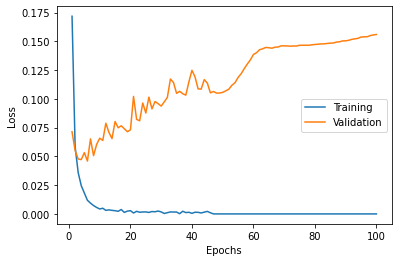

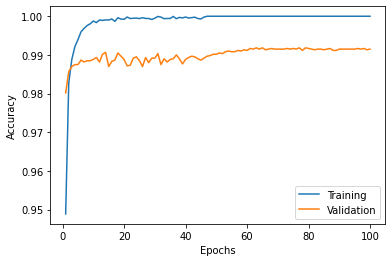

In [ ]:
trainCNN(MNIST_CNN, MNISTx_train, MNISTy_train, 100, 32)

Observing the graphs on the training of the `MNIST_CNN` network it is possible to notice the overfitting of the network; in fact the validation accuracy curve maintained more or less constantly a distance from the train curve up to the last training period. 

In [ ]:
testCNN(MNIST_CNN, MNISTx_test, MNISTy_test)

test loss: 0.13830411434173584
test accuracy: 0.9887999892234802


Despite an presumed situation of overfitting on the training data, observing the results of `testCNN(MNIST_CNN, MNISTx_test, MNISTy_test)`, the model recorded an excellent accuracy, equal to about $98\%$.

My hypothesis of network overfitting based on the above graphs is probably wrong due to the cutting of the axes, which shows a greater distance between the two curves ($d \sim 0.01$).

### CIFAR Network

As a last step of the exercise I modeled a network for the *CIFAR* dataset whose images, as previously shown, have different dimensions from the *MNIST*.

The following output displays the newly defined `CIFAR_CNN` network configuration.

In [ ]:
CIFAR_CNN = createCNN(CIFARinput_shape, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               921728    
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                        

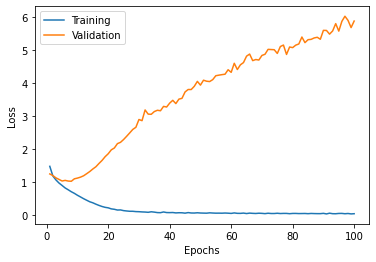

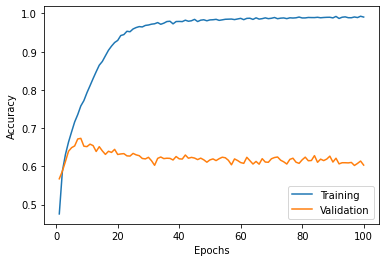

In [ ]:
trainCNN(CIFAR_CNN, CIFARx_train, CIFARy_train, 100, 32)

Following the training, through the two images it is possible to observe how much worse the network is for this task than the previous one: the model is much more overfitted on *CIFAR* data.

Although the model during the training has obtained about $100\%$ accuracy, it is observed that the results obtained on the test set are much worse than the previous model as a result of the problem of overfitting. 

In [ ]:
testCNN(CIFAR_CNN, CIFARx_test, CIFARy_test)

test loss: 5.956062316894531
test accuracy: 0.5925999879837036
